In [1]:
from pyspark.sql import SparkSession
import numpy as np
import itertools
import math
from pyspark.ml.linalg import SparseVector
from pyspark.mllib.linalg import DenseVector
from pyspark.sql import Row

In [2]:
# create spark session
app_name = "final_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

## Factorization machines using gradient descent

In [3]:
# initialize learning rate, number of latent factors, mean, standard deviation
learning_rate = 0.01
num_latent_factors = 10
# used for initializing the parameters for factorized interactions
mean = 0
# used for initializing the parameters for factorized interactions
std = 0.01

In [4]:
# initializing the regularization parameters
# techincally these should come from cross validation
reg_bias = 0.01
reg_independent = 0.01
reg_interaction = np.full(num_latent_factors, 0.01)

In [5]:
def prediction_calculation(features, w0, W, V):
    # dot product of independent features and weights
    # appending the bias term as well
    independent_features = np.append([1.0], features)
    independent_weights = np.append([w0], W)
    
    # get combinations of features for the interaction terms with degree 2
    total_interaction = 0.0
    for subset in itertools.combinations(enumerate(features),2):
        index1 = int(subset[0][0])
        index2 = int(subset[1][0])
        feature1 = float(subset[0][1])
        feature2 = float(subset[1][1])
        # dot product of v parameters and features
        total_interaction += np.dot(V[index1],V[index2]) * feature1 * feature2
    y_hat = np.dot(independent_features,independent_weights) + total_interaction
    return y_hat

In [90]:
def get_parameter_gradients(data, w0, W, V, num_features, num_latent_factors):
    y = data['label']
    features_vec = data['features']
    features, W, V = get_params_features_for_vectors(features_vec, W, V)
    #num_features = num_features_b.value
    y_hat = prediction_calculation(features, w0, W, V)
    # converting the features vector representation to array to get the entire representation
    features_array = features_vec.toArray()
    
    # calculating w0 gradients
    w0_gradient = (1.0/(1.0+math.exp(-y_hat))) - y
    yield ('w0', [w0_gradient])
    
    # calculating W gradients
    W_gradient = w0_gradient*features_array
    yield ('W', [W_gradient])
    
    # calculating V gradients
    # calculating the sum part of the the differenciation_interaction
    sum_v_features = np.zeros((num_features,num_latent_factors))
    # executing xl*sum(vj,f * xj) where j!= l (for all j features except l)
    for i, feature in enumerate(features_array):
        # if the feature is zero no need to compute the sum, we will have a vector of zeros for it
        if feature != 0:
            # handle the first and last elements
            if i == 0:
                sum_v_features[i] = np.dot(features[i+1:],V[i+1:,:])
                continue
            if i == num_features-1:
                sum_v_features[i] = np.dot(features[:i],V[:i,:])
                continue
            sum_v_features[i] = np.dot(np.concatenate((features[:i], features[i+1:])),np.concatenate((V[:i,:], V[i+1:,:])))
    # reshape the feature vector to be able to multiple each feature with it's sum of (vj,f*xj) to compute the expression
    # xl*sum(vj,f * xj) where j!= l (for all j features except l)
    feature_reshape = np.reshape(features_array, (num_features, 1))
    # now multiply to get the entire V at once
    differenciation_interaction = np.multiply(feature_reshape,sum_v_features)
    V_gradient = w0_gradient*differenciation_interaction
    yield ('V', [V_gradient])

In [105]:
def get_log_sigmoid(data):
    y, y_hat = data
    sigmoid = 1.0/(1.0+math.exp(-y_hat))
    
    if int(y) == 1:
        yield -np.log(sigmoid)
    else:
        yield -np.log(1-sigmoid)

In [8]:
def get_log_loss(data_rdd, w0, W, V):
    # calculation the log loss
    loss = data_rdd.map(lambda data: (data['label'], prediction_calculation(data['features'],w0,W,V)))\
                   .flatMap(get_log_sigmoid)\
                   .mean()
    
    return loss

In [91]:
def get_params_features_for_vectors(features, W, V):
    # unpacking the sparse vector to get the respective weights for the features and using just the values present
    if type(features) == SparseVector:
        W_vec = W[features.indices]
        V_vec = V[features.indices]
        features_vec = features.values
    else:
        W_vec = W
        V_vec = V
        features_vec = features

    return features_vec, W_vec, V_vec

In [93]:
def fm_gd(train_rdd, validation_rdd, learning_rate, num_latent_factors, mean, std, reg_bias, reg_independent, reg_interaction, num_steps):    
    
    num_features = train_rdd.take(1)[0]['features'].size 
    print('num_features:',num_features)
    # initialize the model parameters
    w0 = 0.0
    W = np.zeros(num_features)
    V = np.random.normal(mean, std, (num_features,num_latent_factors))
    
    num_features_b = sc.broadcast(num_features)
    num_latent_factors_b = sc.broadcast(num_latent_factors)
    
    # initialize lists to track model performance
    train_history, validation_history = [], []
    
    for i in range(num_steps):
        # broadcast the model parameters
        w0_b = sc.broadcast(w0)
        W_b = sc.broadcast(W)
        V_b = sc.broadcast(V)

        # calculate all gradients for w0, W and V
        all_gradients_rdd = train_rdd.flatMap(lambda x: get_parameter_gradients(x,w0,W,V,num_features,num_latent_factors))\
                                     .reduceByKey(lambda x, y: x + y)\
                                     .cache()
        # perform w0 updates
        w0_gradient = all_gradients_rdd.filter(lambda x: x[0] == 'w0')\
                                       .flatMap(lambda x: x[1])\
                                       .mean()
        w0 -= learning_rate * (w0_gradient + 2 * reg_bias * w0)
        
        # perform W updates
        W_gradient = all_gradients_rdd.filter(lambda x: x[0] == 'W')\
                                       .flatMap(lambda x: x[1])\
                                       .mean()
        W -= learning_rate * (W_gradient + 2 * reg_independent * W)
        
        # perform V updates
        V_gradient = all_gradients_rdd.filter(lambda x: x[0] == 'V')\
                                       .flatMap(lambda x: x[1])\
                                       .mean()
        V -= learning_rate * (V_gradient + 2 * np.multiply(reg_interaction, V))
        
        # find train and validation loss at each iteration
        training_loss = get_log_loss(train_rdd, w0, W, V)
        validation_loss = get_log_loss(validation_rdd, w0, W, V)
        
        # keep track of validation/train loss for plotting
        train_history.append(training_loss)
        validation_history.append(validation_loss)
        
        
    return w0, W, V, train_history, validation_history


In [11]:
# train set
train_df = spark.read.parquet('dac/smallTrainSample.parquet')

In [12]:
# train, validation split set
train_df, validation_df = train_df.randomSplit([.9, .1], 10)
train_df = train_df.cache()
validation_df = validation_df.cache()

In [13]:
# create rdd from df
train_rdd = train_df.rdd.cache()
validation_rdd = validation_df.rdd.cache()

In [106]:
w0, W, V, train_loss, validation_loss = fm_gd(train_rdd, validation_rdd, learning_rate, num_latent_factors, mean, std, reg_bias, reg_independent, reg_interaction, 10)


num_features: 9


In [15]:
# plot error curves
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of log loss) , testLoss (list of log loss)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Log Loss error')
    if title:
        plt.title(title)
    plt.show()

In [16]:
# predict
def predict_classes_correct(data, w0, W, V):
    features_vec = data['features']
    features, W, V = get_params_features_for_vectors(features_vec, W, V)
    y_hat = prediction_calculation(features, w0, W, V)
    sigmoid = 1.0/(1.0+math.exp(-y_hat))
    if sigmoid >= 0.5:
        if int(data['label']) == 1:
            yield ('correct', 1)
        else:
            yield ('wrong', 1)
    else:
        if int(data['label']) == 0:
            yield ('correct', 1)
        else:
            yield ('wrong', 1)

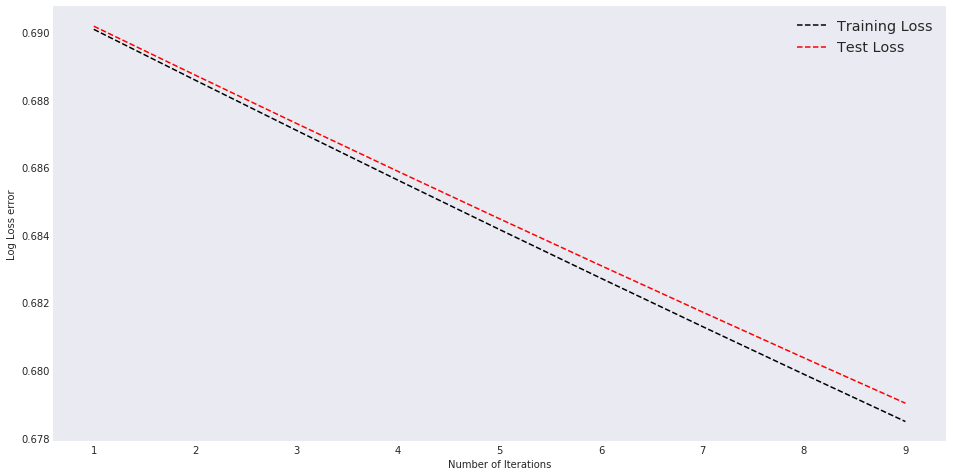

In [107]:
plotErrorCurves(train_loss, validation_loss)

In [18]:
# test set
test_df = spark.read.parquet('dac/smallTestSample.parquet')
test_rdd = test_df.rdd.cache()

In [19]:
test_rdd.count()

10365

In [108]:
# get the predicted classes for the test set
result = test_rdd.flatMap(lambda x: predict_classes_correct(x, w0, W, V)).reduceByKey(lambda x,y: x + y).collect()


In [109]:
result

[('wrong', 2680), ('correct', 7685)]

## Logistic Regression with just independent variables

In [65]:
def prediction_calculation_independent(features, w0, W):
    # dot product of independent features and weights
    # appending the bias term as well
    independent_features = np.append([1.0], features)
    independent_weights = np.append([w0], W)
    
    y_hat = np.dot(independent_features,independent_weights)
    return y_hat

In [66]:
def get_parameter_gradients_independent(data, w0, W, num_features):
    y = data['label']
    features_vec = data['features']
    features, W_condensed = get_params_features_for_vectors_independent(features_vec, W)
    #num_features = num_features_b.value
    y_hat = prediction_calculation_independent(features, w0, W_condensed)
    # converting the features vector representation to array to get the entire representation
    features_array = features_vec.toArray()
    
    # calculating w0 gradients
    w0_gradient = (1.0/(1.0+math.exp(y_hat))) - y
    yield ('w0', [w0_gradient])
    
    # calculating W gradients
    W_gradient = w0_gradient*features_array
    yield ('W', [W_gradient])

In [67]:
def get_log_loss_independent(data_rdd, w0, W):
    # calculation the log loss
    loss = data_rdd.map(lambda data: (data['label'], prediction_calculation_independent(data['features'],w0,W)))\
                   .flatMap(get_log_sigmoid_independent)\
                   .mean()
    
    return loss

In [102]:
def get_log_sigmoid_independent(data):
    y, y_hat = data
    sigmoid = 1.0/(1.0+math.exp(-y_hat))
    
    if int(y) == 1:
        yield -np.log(sigmoid)
    else:
        yield -np.log(1-sigmoid)

In [69]:
def get_params_features_for_vectors_independent(features, W):
    # unpacking the sparse vector to get the respective weights for the features and using just the values present
    if type(features) == SparseVector:
        W_vec = W[features.indices]
        features_vec = features.values
    else:
        W_vec = W
        features_vec = features

    return features_vec, W_vec

In [70]:
def logistic_gd_new(train_rdd, validation_rdd, learning_rate, mean, std, reg_bias, reg_independent, reg_interaction, num_steps):    
    
    num_features = train_rdd.take(1)[0]['features'].size 
    print('num_features:',num_features)
    # initialize the model parameters
    w0 = 0.0
    W = np.zeros(num_features)
    
    num_features_b = sc.broadcast(num_features)
    
    # initialize lists to track model performance
    train_history, validation_history = [], []
    
    for i in range(num_steps):
        # broadcast the model parameters
        w0_b = sc.broadcast(w0)
        W_b = sc.broadcast(W)

        # calculate all gradients for w0, W and V
        all_gradients_rdd = train_rdd.flatMap(lambda x: get_parameter_gradients_independent(x,w0,W,num_features))\
                                     .reduceByKey(lambda x, y: x + y)\
                                     .cache()
        # perform w0 updates
        w0_gradient = all_gradients_rdd.filter(lambda x: x[0] == 'w0')\
                                       .flatMap(lambda x: x[1])\
                                       .mean()
        w0 -= learning_rate * w0_gradient
        
        # perform W updates
        W_gradient = all_gradients_rdd.filter(lambda x: x[0] == 'W')\
                                       .flatMap(lambda x: x[1])\
                                       .mean()
        W -= learning_rate * (W_gradient + 2 * reg_independent * W)
        
        # find train and validation loss at each iteration
        training_loss = get_log_loss_independent(train_rdd, w0, W)
        validation_loss = get_log_loss_independent(validation_rdd, w0, W)
        
        # keep track of validation/train loss for plotting
        train_history.append(training_loss)
        validation_history.append(validation_loss)
        
        
    return w0, W, train_history, validation_history


In [103]:
w0_l, W_l, train_loss_l, validation_loss_l = logistic_gd_new(train_rdd, validation_rdd, learning_rate, mean, std, reg_bias, reg_independent, reg_interaction, 10)


num_features: 9


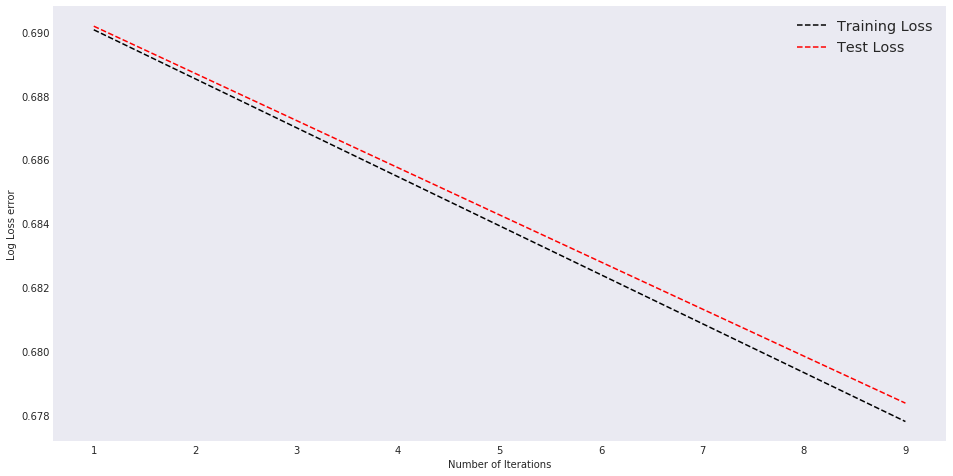

In [104]:
plotErrorCurves(train_loss_l, validation_loss_l)

In [83]:
# predict
def predict_classes_correct_independent(data, w0, W):
    features_vec = data['features']
    features, W_condensed = get_params_features_for_vectors_independent(features_vec, W)
    y_hat = prediction_calculation_independent(features, w0, W_condensed)
    sigmoid = 1.0/(1.0+math.exp(-y_hat))
    if sigmoid >= 0.5:
        if int(data['label']) == 1:
            yield ('correct', 1)
        else:
            yield ('wrong', 1)
    else:
        if int(data['label']) == 0:
            yield ('correct', 1)
        else:
            yield ('wrong', 1)

In [84]:
# get the predicted classes for the test set
result = test_rdd.flatMap(lambda x: predict_classes_correct_independent(x, w0_l, W_l)).reduceByKey(lambda x,y: x + y).collect()


In [85]:
result

[('wrong', 2680), ('correct', 7685)]